In [1]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.7 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
from scipy import signal
#import wave, math
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as shc
from sklearn.metrics.pairwise import pairwise_distances
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from tabulate import tabulate
from termcolor import colored
from IPython.display import display, HTML
import math
from scipy.spatial.distance import squareform
from dtaidistance import dtw
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage
import time
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from IPython.display import display, Latex
from sklearn.metrics import mean_absolute_error

In [3]:
# granger imports
from __future__ import annotations

from statsmodels.compat.numpy import lstsq
from statsmodels.compat.pandas import deprecate_kwarg
# from statsmodels.compat.python import Literal, lzip
from statsmodels.compat.scipy import _next_regular

from typing import Union, List
import warnings

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from scipy.signal import correlate

from statsmodels.regression.linear_model import OLS, yule_walker
from statsmodels.tools.sm_exceptions import (
    CollinearityWarning,
    InfeasibleTestError,
    InterpolationWarning,
    MissingDataError,
    ValueWarning,
)
from statsmodels.tools.tools import Bunch, add_constant
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    dict_like,
    float_like,
    int_like,
    string_like,
)
from statsmodels.tsa._bds import bds
from statsmodels.tsa._innovations import innovations_algo, innovations_filter
from statsmodels.tsa.adfvalues import mackinnoncrit, mackinnonp
from statsmodels.tsa.tsatools import add_trend, lagmat, lagmat2ds

In [5]:
# if on google colab / drive
# from google.colab import drive
# drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# insert your own base_dir accordingly
base_dir = ""

# Setup Time Series

## Causal

Going to assess lag order selection across 3 different levels of noise

In [7]:
weights = [1,1,1,1,1,1]

noises = [[1,1,1,1,1,1],
          [2,2,2,2,2,2],
          [3,3,3,3,3,3]]

In [8]:
ts_len = 1000 # Length of time series
causal_timeseries_no_noise = []
causal_timeseries = []
cluster_size = 4 # Number of Alpha TS per cluster
output_num = 3 # Number of beta TS per cluster
num_clusters = 6 # Number of clusters

for _ in range(num_clusters*cluster_size): # 24
    ts = np.zeros(ts_len) # initiate with length 1000
    # Events, change 1.5 for more sparse/dense ts
    for i in range(len(ts)):
        if random.gauss(0,1) > 1.5: # sample from gaussian with 0 mean and 1 std
            ts[i] = 1
    # Sinc
    x = np.linspace(-4, 4, 11)
    ts = np.convolve(ts,np.sinc(x), 'same')
    causal_timeseries_no_noise.append(ts)
    # Noise
    ts = np.sum([ts, np.random.normal(0,0.3,ts_len)], axis=0)
    causal_timeseries.append(ts)

for x in causal_timeseries:
    if adfuller(x)[1] > 0.05:
        print("Not Stationary")

# np.save(base_dir + "causal_timeseries.npy", causal_timeseries)

In [9]:
ts_len = 1000 # Length of time series
causal_timeseries = []
cluster_size = 4 # Number of Alpha TS per cluster
output_num = 3 # Number of beta TS per cluster
num_clusters = 6 # Number of clusters
causal_timeseries = np.load(base_dir + "Lag_Order_Selection_Data_and_Figures/causal_timeseries.npy")

## Effect

In [10]:
def generate_effect(causal_timeseries, causal_timeseries_no_noise, w, n):

    # Get the raw betas so signal power can be calculated
    effects_no_noise = []
    for c in range(num_clusters):
        ts_cluster = causal_timeseries_no_noise[c*cluster_size:c*cluster_size+cluster_size]
        for d in range(output_num):
            weights = np.full(cluster_size, w[c])
            effect_no_noise = np.sum([weights.dot(ts_cluster)], axis=0)
            effects_no_noise.append(effect_no_noise)

    noises = []

    # calculate the effect series themselves while saving out the noise
    effect_timeseries = []
    lags = []
    global_counter = 0
    for c in range(num_clusters):
        ts_cluster = causal_timeseries[c*cluster_size:c*cluster_size+cluster_size]
        for d in range(output_num):
            weights = np.full(cluster_size, w[c]) # make weight matrix
            lag = np.random.randint(7,21) # generate a lag and save it for comparison later
            lags.append(lag)
            output = np.roll(weights.dot(ts_cluster), lag) # apply weights and shift timeseries
            output = np.sum([output, np.random.normal(0,n[c],ts_len)], axis=0) # take down to 1d and add noise
            effect_timeseries.append(output)

            # get the noise minus original signal
            temp_output = weights.dot(ts_cluster)
            temp_output = np.sum([output, np.random.normal(0,n[c],ts_len)], axis=0)
            noises.append(temp_output - effects_no_noise[global_counter])
            global_counter += 1

    for x in effect_timeseries:
        if adfuller(x)[1] > 0.5:
            print("Not Stationary")

    return effect_timeseries, lags, effects_no_noise, noises

#### Determining SNR of each batch of effect time series

In [11]:
effect_timeseries, gtl, effects_no_noise, noises_temp = generate_effect(causal_timeseries, causal_timeseries_no_noise, weights, noises[0])
snr1 = []
for i in range(len(effects_no_noise)):
    temp = 10 * np.log10(
        np.mean(effects_no_noise[i]**2) /
        np.mean(noises_temp[i]**2)
        )
    snr1.append(temp)

effect_timeseries, gtl, effects_no_noise, noises_temp = generate_effect(causal_timeseries, causal_timeseries_no_noise, weights, noises[1])
snr2 = []
for i in range(len(effects_no_noise)):
    temp = 10 * np.log10(
        np.mean(effects_no_noise[i]**2) /
        np.mean(noises_temp[i]**2)
        )
    snr2.append(temp)

effect_timeseries, gtl, effects_no_noise, noises_temp = generate_effect(causal_timeseries, causal_timeseries_no_noise, weights, noises[2])
snr3 = []
for i in range(len(effects_no_noise)):
    temp = 10 * np.log10(
        np.mean(effects_no_noise[i]**2) /
        np.mean(noises_temp[i]**2)
        )
    snr3.append(temp)

print("SNR1: ", np.average(snr1))
print("SNR2: ", np.average(snr2))
print("SNR3: ", np.average(snr3))

SNR1:  -8.49689805152463
SNR2:  -13.236069872879979
SNR3:  -16.59294009280786


In [12]:
effect_timeseries_groups = []
effect_timeseries_no_noise_groups = []
noises_groups = []
ground_truth_lags = []
pred_lags = []
granger_results_groups_final = []
for i, _ in enumerate(noises):
    # get effect ts
    effect_timeseries, gtl, effects_no_noise, noises_temp = generate_effect(causal_timeseries, causal_timeseries_no_noise, weights, noises[i])
    ground_truth_lags.append(gtl)
    effect_timeseries_groups.append(effect_timeseries)
    effect_timeseries_no_noise_groups.append(effects_no_noise)
    noises_groups.append(noises_temp)

In [13]:
# effect_timeseries_groups = []
# ground_truth_lags = []
# pred_lags = []
# granger_results_groups_final = []
# for i, _ in enumerate(noises):
#     # get effect ts
#     effect_timeseries, gtl = generate_effect(causal_timeseries, weights, noises[i])
#     ground_truth_lags.append(gtl)
#     effect_timeseries_groups.append(effect_timeseries)
#     np.save(base_dir + 'Lag_Order_Selection_Investigation_Notebook/' + "effect_noise" + str(i+1) + ".npy", effect_timeseries)

# np.save(base_dir + 'Lag_Order_Selection_Investigation_Notebook/ground_truth_lags_for_123_effect_gaussian_noise.npy', ground_truth_lags)



In [14]:
effect_timeseries_groups = []
effect_ts_file_names = ["effect_noise1.npy", "effect_noise2.npy", "effect_noise3.npy"]
for name in effect_ts_file_names:
    effect_timeseries_groups.append(np.load(base_dir + 'Lag_Order_Selection_Data_and_Figures/' + name))

ground_truth_lags = np.load(base_dir + 'Lag_Order_Selection_Data_and_Figures/ground_truth_lags_for_123_effect_gaussian_noise.npy')

# Define Granger

In [15]:
def grangercausalitytests_custom(x, maxlag, addconst=True, verbose=None):
    """
    Four tests for granger non causality of 2 time series.

    All four tests give similar results. `params_ftest` and `ssr_ftest` are
    equivalent based on F test which is identical to lmtest:grangertest in R.

    Parameters
    ----------
    x : array_like
        The data for testing whether the time series in the second column Granger
        causes the time series in the first column. Missing values are not
        supported.
    maxlag : {int, Iterable[int]}
        If an integer, computes the test for all lags up to maxlag. If an
        iterable, computes the tests only for the lags in maxlag.
    addconst : bool
        Include a constant in the model.
    verbose : bool
        Print results. Deprecated

        .. deprecated: 0.14

           verbose is deprecated and will be removed after 0.15 is released



    Returns
    -------
    dict
        All test results, dictionary keys are the number of lags. For each
        lag the values are a tuple, with the first element a dictionary with
        test statistic, pvalues, degrees of freedom, the second element are
        the OLS estimation results for the restricted model, the unrestricted
        model and the restriction (contrast) matrix for the parameter f_test.

    Notes
    -----
    TODO: convert to class and attach results properly

    The Null hypothesis for grangercausalitytests is that the time series in
    the second column, x2, does NOT Granger cause the time series in the first
    column, x1. Grange causality means that past values of x2 have a
    statistically significant effect on the current value of x1, taking past
    values of x1 into account as regressors. We reject the null hypothesis
    that x2 does not Granger cause x1 if the pvalues are below a desired size
    of the test.

    The null hypothesis for all four test is that the coefficients
    corresponding to past values of the second time series are zero.

    `params_ftest`, `ssr_ftest` are based on F distribution

    `ssr_chi2test`, `lrtest` are based on chi-square distribution

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Granger_causality

    .. [2] Greene: Econometric Analysis

    Examples
    --------
    >>> import statsmodels.api as sm
    >>> from statsmodels.tsa.stattools import grangercausalitytests
    >>> import numpy as np
    >>> data = sm.datasets.macrodata.load_pandas()
    >>> data = data.data[["realgdp", "realcons"]].pct_change().dropna()

    All lags up to 4

    >>> gc_res = grangercausalitytests(data, 4)

    Only lag 4

    >>> gc_res = grangercausalitytests(data, [4])
    """
    x = array_like(x, "x", ndim=2)
    if not np.isfinite(x).all():
        raise ValueError("x contains NaN or inf values.")
    addconst = bool_like(addconst, "addconst")
    if verbose is not None:
        verbose = bool_like(verbose, "verbose")
        warnings.warn(
            "verbose is deprecated since functions should not print results",
            FutureWarning,
        )
    else:
        verbose = True  # old default

    try:
        maxlag = int_like(maxlag, "maxlag")
        if maxlag <= 0:
            raise ValueError("maxlag must be a positive integer")
        lags = np.arange(1, maxlag + 1)
    except TypeError:
        lags = np.array([int(lag) for lag in maxlag])
        maxlag = lags.max()
        if lags.min() <= 0 or lags.size == 0:
            raise ValueError(
                "maxlag must be a non-empty list containing only "
                "positive integers"
            )

    if x.shape[0] <= 3 * maxlag + int(addconst):
        raise ValueError(
            "Insufficient observations. Maximum allowable "
            "lag is {}".format(int((x.shape[0] - int(addconst)) / 3) - 1)
        )

    resli = {}

    for mlg in lags:
        result = {}
        if verbose:
            print("\nGranger Causality")
            print("number of lags (no zero)", mlg)
        mxlg = mlg

        # create lagmat of both time series
        dta = lagmat2ds(x, mxlg, trim="both", dropex=1)

        # add constant
        if addconst:
            dtaown = add_constant(dta[:, 1 : (mxlg + 1)], prepend=False)
            dtajoint = add_constant(dta[:, 1:], prepend=False)
            if (
                dtajoint.shape[1] == (dta.shape[1] - 1)
                or (dtajoint.max(0) == dtajoint.min(0)).sum() != 1
            ):
                raise InfeasibleTestError(
                    "The x values include a column with constant values and so"
                    " the test statistic cannot be computed."
                )
        else:
            raise NotImplementedError("Not Implemented")
            # dtaown = dta[:, 1:mxlg]
            # dtajoint = dta[:, 1:]

        # Run ols on both models without and with lags of second variable
        res2down = OLS(dta[:, 0], dtaown).fit()
        res2djoint = OLS(dta[:, 0], dtajoint).fit()

        # print results
        # for ssr based tests see:
        # http://support.sas.com/rnd/app/examples/ets/granger/index.htm
        # the other tests are made-up

        # Granger Causality test using ssr (F statistic)
        if res2djoint.model.k_constant:
            tss = res2djoint.centered_tss
        else:
            tss = res2djoint.uncentered_tss
        if (
            tss == 0
            or res2djoint.ssr == 0
            or np.isnan(res2djoint.rsquared)
            or (res2djoint.ssr / tss) < np.finfo(float).eps
            or res2djoint.params.shape[0] != dtajoint.shape[1]
        ):
            raise InfeasibleTestError(
                "The Granger causality test statistic cannot be compute "
                "because the VAR has a perfect fit of the data."
            )
        fgc1 = (
            (res2down.ssr - res2djoint.ssr)
            / res2djoint.ssr
            / mxlg
            * res2djoint.df_resid
        )
        if verbose:
            print(
                "ssr based F test:         F=%-8.4f, p=%-8.4f, df_denom=%d,"
                " df_num=%d"
                % (
                    fgc1,
                    stats.f.sf(fgc1, mxlg, res2djoint.df_resid),
                    res2djoint.df_resid,
                    mxlg,
                )
            )
        result["ssr_ftest"] = (
            fgc1,
            stats.f.sf(fgc1, mxlg, res2djoint.df_resid),
            res2djoint.df_resid,
            mxlg,
        )

        # Granger Causality test using ssr (ch2 statistic)
        fgc2 = res2down.nobs * (res2down.ssr - res2djoint.ssr) / res2djoint.ssr
        if verbose:
            print(
                "ssr based chi2 test:   chi2=%-8.4f, p=%-8.4f, "
                "df=%d" % (fgc2, stats.chi2.sf(fgc2, mxlg), mxlg)
            )
        result["ssr_chi2test"] = (fgc2, stats.chi2.sf(fgc2, mxlg), mxlg)

        # likelihood ratio test pvalue:
        lr = -2 * (res2down.llf - res2djoint.llf)
        if verbose:
            print(
                "likelihood ratio test: chi2=%-8.4f, p=%-8.4f, df=%d"
                % (lr, stats.chi2.sf(lr, mxlg), mxlg)
            )
        result["lrtest"] = (lr, stats.chi2.sf(lr, mxlg), mxlg)

        # F test that all lag coefficients of exog are zero
        rconstr = np.column_stack(
            (np.zeros((mxlg, mxlg)), np.eye(mxlg, mxlg), np.zeros((mxlg, 1)))
        )
        ftres = res2djoint.f_test(rconstr)
        if verbose:
            print(
                "parameter F test:         F=%-8.4f, p=%-8.4f, df_denom=%d,"
                " df_num=%d"
                % (ftres.fvalue, ftres.pvalue, ftres.df_denom, ftres.df_num)
            )
        result["params_ftest"] = (
            np.squeeze(ftres.fvalue)[()],
            np.squeeze(ftres.pvalue)[()],
            ftres.df_denom,
            ftres.df_num,
        )

        result["aic"] = res2djoint.aic
        result["bic"] = res2djoint.bic
        hq = - 2 * res2djoint.llf + 2 * mxlg * np.log(np.log(res2djoint.nobs))
        result["hq"] = hq
        result["llf_unrestricted"] = res2djoint.llf
        result["llf_restricted"] = res2down.llf
        result["ssr_restricted"] = res2down.ssr
        result["ssr_unrestricted "]= res2djoint.ssr
        result["nobs"] = res2djoint.nobs
        result["params"] = len(res2djoint.params)

        # print(res2djoint.summary())
        # if (mxlg == 21):
        #     return res2djoint

        # resli[mxlg] = (result, [-1]) # put -1 here to save on RAM (before it was [res2down, res2djoint, rconstr])
        resli[mxlg] = (result, [res2down, res2djoint, rconstr])

    return resli


# Lag Order selection testing

## Seq LR Testing

In [16]:
def modified_seq_LLR_test(results, maxlag, threshold):
    M = maxlag
    i = 1
    while i < M:
        lr = - 2 * (results[M - i][0]['llf_unrestricted'] - results[M - i + 1][0]['llf_unrestricted'])
        if (stats.chi2.sf(lr, 2) < threshold):
            return M - i + 1
        i += 1
    return -1

def original_seq_LR_test(results, maxlag, threshold):
    M = maxlag
    i = 1
    while i < M:
        nobs = results[M - i][1][1].nobs # [1] acess the models [1][1] access the unrestricted model. We want the M - 1 nobs because it represents the common observations
        resid_cov_1 = 1 / nobs * np.dot(results[M-i][1][1].resid.T,results[M-i][1][1].resid)
        resid_cov_2 = 1 / nobs * np.dot(results[M-i+1][1][1].resid.T,results[M-i+1][1][1].resid)
        lr = nobs * (np.log(resid_cov_1) - np.log(resid_cov_2))

        if (stats.chi2.sf(lr, 2) < threshold):
            return M - i + 1
        i += 1
    return -1

def og_slr(results, maxlag, threshold):
    M = maxlag
    i = 1
    while i < M:
        nobs = results[M - i][1][1].nobs # [1] acess the models [1][1] access the unrestricted model. We want the M - 1 nobs because it represents the common observations
        resid_cov_1 = 1 / nobs * np.dot(results[M-i][1][1].resid.T,results[M-i][1][1].resid)
        resid_cov_2 = 1 / nobs * np.dot(results[M-i+1][1][1].resid.T,results[M-i+1][1][1].resid)
        lr = (nobs - 2 * (M - i + 1)) * (np.log(resid_cov_1) - np.log(resid_cov_2))

        if (stats.chi2.sf(lr, 2) < threshold):
            return M - i + 1
        i += 1
    return -1


def get_granger_matrix_with_sequential_lr_test(causal_timeseries, effect_timeseries):
    import warnings
    warnings.filterwarnings('ignore')
    lags_original_seqlrs5 = []
    lags_original_seqlrs1 = []
    lags_ogslr_1 = []
    lags_ogslr_5 = []
    for cts in causal_timeseries:
        row_original_seqlrs5 = []
        row_original_seqlrs1 = []
        row_ogslr_1 = []
        row_ogslr_5 = []
        for ets in effect_timeseries:
            g_input = np.concatenate([np.vstack(ets), np.vstack(cts)], axis=1)
            results = grangercausalitytests_custom(g_input, maxlag=21, verbose=0)


            row_original_seqlrs5.append(original_seq_LR_test(results, 21, 0.05))
            row_original_seqlrs1.append(original_seq_LR_test(results, 21, 0.01))

            row_ogslr_1.append(og_slr(results, 21, 0.01))
            row_ogslr_5.append(og_slr(results, 21, 0.05))

        lags_original_seqlrs5.append(row_original_seqlrs5)
        lags_original_seqlrs1.append(row_original_seqlrs1)
        lags_ogslr_1.append(row_ogslr_1)
        lags_ogslr_5.append(row_ogslr_5)

    return {"lags_original_seqlrs5": lags_original_seqlrs5, "lags_original_seqlrs1": lags_original_seqlrs1, "lags_ogslr_1": lags_ogslr_1, "lags_ogslr_5":lags_ogslr_5}

In [17]:
pred_lags_lrs = []
for i, effect_timeseries in enumerate(effect_timeseries_groups):
    # get predicted_lags
    pl = get_granger_matrix_with_sequential_lr_test(causal_timeseries, effect_timeseries)
    pred_lags_lrs.append(pl)

KeyboardInterrupt: 

In [18]:
# np.save(base_dir + 'Lag_Order_Selection_Data_and_Figures/pred_lags_lr_slr_for_123_effect_gaussian_noise.npy', pred_lags_lrs)
pred_lags_lrs = np.load(base_dir + 'Lag_Order_Selection_Data_and_Figures/pred_lags_lr_slr_for_123_effect_gaussian_noise.npy', allow_pickle=True)

## Granger, AIC, BIC, HQIC Testing

In [19]:
def get_granger_matrix_with_aic_bic(causal_timeseries, effect_timeseries):
    import warnings
    warnings.filterwarnings('ignore')
    granger_results_pval = []
    granger_results_aic = []
    granger_results_bic = []
    granger_results_hq = []
    lags_pval = []
    lags_aic = []
    lags_bic = []
    lags_hq = []
    all_results = []
    for cts in causal_timeseries:
        gres_ps = []
        gres_aic = []
        gres_bic = []
        gres_hq = []
        chosen_lag_pval = []
        chosen_lag_aic = []
        chosen_lag_bic = []
        chosen_lag_hq = []
        for ets in effect_timeseries:
            g_input = np.concatenate([np.vstack(ets), np.vstack(cts)], axis=1)
            results = grangercausalitytests_custom(g_input, maxlag=21, verbose=0)
            p_vals = []
            aics = []
            bics = []
            hqs = []
            for i, lag in enumerate(results):
                p_vals.append(results[lag][0]['ssr_ftest'][1])
                aics.append(results[lag][0]['aic'])
                bics.append(results[lag][0]['bic'])
                hqs.append(results[lag][0]['hq'])
            all_results.append(results)

            # min pvalue
            min_pval = min(p_vals)
            min_pval_lag = np.argmin(p_vals) + 1 # + 1 because lag is 1 indexed
            chosen_lag_pval.append(min_pval_lag)
            gres_ps.append(min_pval)

            # min aic
            min_aic_lag = np.argmin(aics) + 1
            min_pval_using_aic = p_vals[np.argmin(aics)]
            chosen_lag_aic.append(min_aic_lag)
            gres_aic.append(min_pval_using_aic)

            # min bic
            min_bic_lag = np.argmin(bics) + 1
            min_pval_using_bic = p_vals[np.argmin(bics)]
            chosen_lag_bic.append(min_bic_lag)
            gres_bic.append(min_pval_using_bic)

            # min hq
            min_hq_lag = np.argmin(hqs) + 1
            min_pval_using_hq = p_vals[np.argmin(hqs)]
            chosen_lag_hq.append(min_hq_lag)
            gres_hq.append(min_pval_using_hq)

            # row_lags.append({"p_vals"})
            # gres.append(result)
        granger_results_pval.append(gres_ps)
        granger_results_aic.append(gres_aic)
        granger_results_bic.append(gres_bic)
        granger_results_hq.append(gres_hq)
        lags_pval.append(chosen_lag_pval)
        lags_aic.append(chosen_lag_aic)
        lags_bic.append(chosen_lag_bic)
        lags_hq.append(chosen_lag_hq)

    return {"granger_results_pval": np.array(granger_results_pval), "granger_results_aic": np.array(granger_results_aic), "granger_results_bic": np.array(granger_results_bic), "granger_results_hq": np.array(granger_results_hq)}, {"lags_pval": np.array(lags_pval), "lags_aic": np.array(lags_aic), "lags_bic": np.array(lags_bic), "lags_hq":np.array(lags_hq), "all_results": all_results}

In [20]:
pred_lags = []
for i, effect_timeseries in enumerate(effect_timeseries_groups):
    # get predicted_lags
    _, pl = get_granger_matrix_with_aic_bic(causal_timeseries, effect_timeseries)
    pred_lags.append(pl)

KeyboardInterrupt: 

In [ ]:
# np.save(base_dir + 'Lag_Order_Selection_Data_and_Figures/pred_lags_for_123_effect_gaussian_noise.npy', pred_lags)

In [21]:
pred_lags = np.load(base_dir + 'Lag_Order_Selection_Data_and_Figures/pred_lags_for_123_effect_gaussian_noise.npy', allow_pickle=True)

# Lag Order Selection Analysis

In [22]:
# NEW
import numpy as np
from IPython.display import display, HTML

def produce_lag_coloring(A, B, metric):
    # Colors to use for highlighting
    colors = ['red', 'brown', '#FF8C00', 'blue', 'magenta', '#FF7F50']
    y_true = []
    y_pred = []

    # Add an additional row to B with 0-18
    B = np.vstack([B, np.arange(len(B[0]))])

    def color_element(element, color):
        return f"<span style='color: {color};'>{element}</span>"

    def highlight_array(A, B):
        # Create a list to hold the colored A elements
        colored_A = []

        colored_A.extend([color_element(f"{0:3}", 'white')])
        # Loop through A in chunks of 3
        for i in range(0, len(A), 3):
            color = colors[i // 3 % len(colors)]
            # Highlight the current chunk of A
            colored_A.extend([color_element(f"{A[j]:3}", color) for j in range(i, i + 3)])

        # Create a 2D array to hold the colored B elements
        colored_B = []

        for row_idx, row in enumerate(B):
            colored_row = []
            if row_idx < len(B):  # Regular rows with the 1-24 labels on the left
                if row_idx + 1 == len(B):
                    colored_row.append(f"<span style='color: white;'>{'β' + str(0):3}</span>")
                else:
                    colored_row.append(f"<span style='color: black;'>{'α' + str(row_idx + 1):3}</span>")
            else:  # The bottom row doesn't need a label
                colored_row.append(f"<span style='color: white;'>{row_idx + 1:2}</span>")

            for col_idx, elem in enumerate(row):
                if row_idx < len(B) - 1:  # Regular matrix rows
                    # Determine if this element should be colored
                    block_row = row_idx // 4
                    block_col = col_idx // 3

                    if block_row == block_col:
                        color = colors[block_row % len(colors)]
                        colored_row.append(color_element(f"{elem:3}", color))
                        y_true.append(A[col_idx])
                        y_pred.append(B[row_idx][col_idx])
                    else:
                        colored_row.append(color_element(f"{elem:3}", "#D3D3D3"))
                else:  # The bottom row with 0-18
                    if elem < 9:
                        colored_row.append(f"<span style='color: black;'>{' β' + str(elem + 1):2}</span>")
                    else:
                        colored_row.append(f"<span style='color: black;'>{'β' + str(elem + 1):3}</span>")

            colored_B.append(colored_row)

        # Convert colored arrays to HTML strings
        A_html = " ".join(colored_A)
        B_html = "<br>".join([" ".join(row) for row in colored_B])

        # Display the highlighted arrays with the new column and row
        if (metric == "granger"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by Granger Min P-Value metric: \n{B_html}</pre>"))
        elif (metric == "aic"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by AIC metric: \n{B_html}</pre>"))
        elif (metric == "bic"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by BIC metric: \n{B_html}</pre>"))
        elif (metric == "hq"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by HQ metric: \n{B_html}</pre>"))
        elif (metric == "ogseqlr1"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by Original Seq LR Test with 0.01 metric: \n{B_html}</pre>"))
        elif (metric == "ogseqlr5"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by Original Seq LR Test with 0.05 metric: \n{B_html}</pre>"))
        elif (metric == "ogslr1"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by Original Small-sample corrected Seq LR Test with 0.01 metric: \n{B_html}</pre>"))
        elif (metric == "ogslr5"):
            display(HTML(f"<pre>Ground Truth Lag for each β timeseries:\n{A_html}\n\nLags chosen by Original Small-sample corrected Seq LR Test with 0.05 metric: \n{B_html}</pre>"))
    highlight_array(A, B)

    # mse = np.square(np.subtract(y_true,y_pred)).mean()
    mae = mean_absolute_error(y_true,y_pred)
    print('\033[1m' + f"\nMAE Across Regions of Interest: {mae}" + '\033[0m')
    return mae

In [23]:
granger_maes = []
bic_maes = []
aic_maes = []
hq_maes = []
og_seqlr1_maes = []
og_seqlr5_maes = []
og_slr1_maes = []
og_slr5_maes = []

## Noise 1

In [24]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags[0]["lags_pval"], "granger")
granger_maes.append(temp_mse)


MAE Across Regions of Interest: 0.4166666666666667


In [25]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags[0]["lags_aic"], "aic")
aic_maes.append(temp_mse)


MAE Across Regions of Interest: 6.930555555555555


In [26]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags[0]["lags_bic"], "bic")
bic_maes.append(temp_mse)


MAE Across Regions of Interest: 6.152777777777778


In [27]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags[0]["lags_hq"], "hq")
hq_maes.append(temp_mse)


MAE Across Regions of Interest: 7.25


In [28]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags_lrs[0]["lags_original_seqlrs5"], "ogseqlr5")
og_seqlr5_maes.append(temp_mse)


MAE Across Regions of Interest: 3.138888888888889


In [29]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags_lrs[0]["lags_original_seqlrs1"], "ogseqlr1")
og_seqlr1_maes.append(temp_mse)


MAE Across Regions of Interest: 1.125


In [30]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags_lrs[0]["lags_ogslr_1"], "ogslr1")
og_slr1_maes.append(temp_mse)


MAE Across Regions of Interest: 0.9027777777777778


In [31]:
temp_mse = produce_lag_coloring(ground_truth_lags[0], pred_lags_lrs[0]["lags_ogslr_5"], "ogslr5")
og_slr5_maes.append(temp_mse)


MAE Across Regions of Interest: 2.986111111111111


## Noise 2

In [32]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags[1]["lags_pval"], "granger")
granger_maes.append(temp_mse)


MAE Across Regions of Interest: 1.0277777777777777


In [33]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags[1]["lags_aic"], "aic")
aic_maes.append(temp_mse)


MAE Across Regions of Interest: 8.027777777777779


In [34]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags[1]["lags_bic"], "bic")
bic_maes.append(temp_mse)


MAE Across Regions of Interest: 11.458333333333334


In [35]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags[1]["lags_hq"], "hq")
hq_maes.append(temp_mse)


MAE Across Regions of Interest: 8.069444444444445


In [36]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags_lrs[1]["lags_original_seqlrs5"], "ogseqlr5")
og_seqlr5_maes.append(temp_mse)


MAE Across Regions of Interest: 4.361111111111111


In [37]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags_lrs[1]["lags_original_seqlrs1"], "ogseqlr1")
og_seqlr1_maes.append(temp_mse)


MAE Across Regions of Interest: 1.25


In [38]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags_lrs[1]["lags_ogslr_1"], "ogslr1")
og_slr1_maes.append(temp_mse)


MAE Across Regions of Interest: 0.9305555555555556


In [39]:
temp_mse = produce_lag_coloring(ground_truth_lags[1], pred_lags_lrs[1]["lags_ogslr_5"], "ogslr5")
og_slr5_maes.append(temp_mse)


MAE Across Regions of Interest: 4.222222222222222


## Noise 3

In [40]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags[2]["lags_pval"], "granger")
granger_maes.append(temp_mse)


MAE Across Regions of Interest: 2.263888888888889


In [41]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags[2]["lags_aic"], "aic")
aic_maes.append(temp_mse)


MAE Across Regions of Interest: 8.61111111111111


In [42]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags[2]["lags_bic"], "bic")
bic_maes.append(temp_mse)


MAE Across Regions of Interest: 11.13888888888889


In [43]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags[2]["lags_hq"], "hq")
hq_maes.append(temp_mse)


MAE Across Regions of Interest: 8.61111111111111


In [44]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags_lrs[2]["lags_original_seqlrs5"], "ogseqlr5")
og_seqlr5_maes.append(temp_mse)


MAE Across Regions of Interest: 4.708333333333333


In [45]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags_lrs[2]["lags_original_seqlrs1"], "ogseqlr1")
og_seqlr1_maes.append(temp_mse)


MAE Across Regions of Interest: 2.3333333333333335


In [46]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags_lrs[2]["lags_ogslr_1"], "ogslr1")
og_slr1_maes.append(temp_mse)


MAE Across Regions of Interest: 2.375


In [47]:
temp_mse = produce_lag_coloring(ground_truth_lags[2], pred_lags_lrs[2]["lags_ogslr_5"], "ogslr5")
og_slr5_maes.append(temp_mse)


MAE Across Regions of Interest: 4.527777777777778


# Boxplot

In [48]:
def make_arrays_for_comparision(pred, gt):
    rows_per_cluster = 4
    prediction_data_of_interest = []
    matching_gt = []
    for i in range(6):
        for r in range(rows_per_cluster):
            prediction_data_of_interest.extend(pred[r+i*4][3*i:3*i+3])
            matching_gt.extend(gt[3*i: 3*i+3])

    abs_diffs = np.array(matching_gt) - np.array(prediction_data_of_interest)
    return abs_diffs

bic_diffs = []
aic_diffs = []
hq_diffs = []
granger_diffs = []
ogseqlr1_diffs = []
ogseqlr5_diffs = []
og_slr1_diffs = []
og_slr5_diffs = []
for i in range(3):
    bic_diffs.append(make_arrays_for_comparision(pred_lags[i]["lags_bic"], ground_truth_lags[i]))
    aic_diffs.append(make_arrays_for_comparision(pred_lags[i]["lags_aic"], ground_truth_lags[i]))
    hq_diffs.append(make_arrays_for_comparision(pred_lags[i]["lags_hq"], ground_truth_lags[i]))
    granger_diffs.append(make_arrays_for_comparision(pred_lags[i]["lags_pval"], ground_truth_lags[i]))
    ogseqlr1_diffs.append(make_arrays_for_comparision(pred_lags_lrs[i]["lags_original_seqlrs1"], ground_truth_lags[i]))
    ogseqlr5_diffs.append(make_arrays_for_comparision(pred_lags_lrs[i]["lags_original_seqlrs5"], ground_truth_lags[i]))
    og_slr1_diffs.append(make_arrays_for_comparision(pred_lags_lrs[i]["lags_ogslr_1"], ground_truth_lags[i]))
    og_slr5_diffs.append(make_arrays_for_comparision(pred_lags_lrs[i]["lags_ogslr_5"], ground_truth_lags[i]))

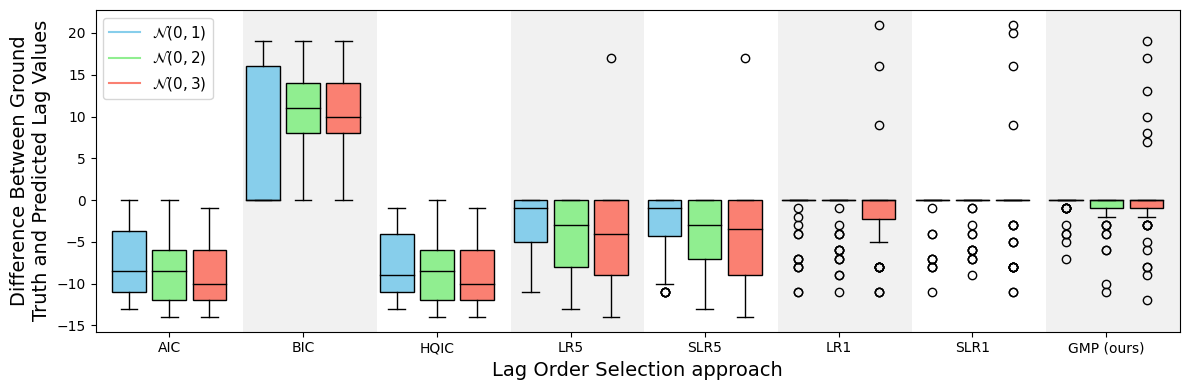

In [49]:
import matplotlib.pyplot as plt

# Grouping data into a list of lists for plotting (Adding the new datasets)
data = [aic_diffs, bic_diffs, hq_diffs, ogseqlr5_diffs, og_slr5_diffs, ogseqlr1_diffs, og_slr1_diffs, granger_diffs]
approaches = ['AIC', 'BIC', 'HQIC', 'LR5',"SLR5", 'LR1', "SLR1", 'GMP (ours)']
noise_levels = [r'$\mathcal{N}(0,1)$', r'$\mathcal{N}(0,2)$', r'$\mathcal{N}(0,3)$']

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Colors for each noise level
noise_colors = ['skyblue', 'lightgreen', 'salmon']

# Calculating the number of groups and the positions for each group
num_groups = len(data)
num_experiments = 3

# Adjust spacing here: smaller number for closer plots within groups, larger for space between groups
group_width = 2
within_group_width = 0.6

positions = []

# Generate positions with adjusted spacing
for i in range(num_groups):
    for j in range(num_experiments):
        # Adding positions with more spacing between groups
        positions.append(i * group_width + j * within_group_width)

# Alternate background colors for each group
for i in range(num_groups):
    start_pos = i * group_width - within_group_width / 2
    end_pos = (i + 1) * group_width - within_group_width / 2
    color = 'lightgray' if i % 2 == 1 else 'white'
    ax.axvspan(start_pos, end_pos, facecolor=color, alpha=0.3)

# Plotting each group with colors
for i, group in enumerate(data):
    for j, experiment in enumerate(group):
        pos_index = i * num_experiments + j
        ax.boxplot(experiment, positions=[positions[pos_index]], widths=0.5, patch_artist=True,
                   boxprops=dict(facecolor=noise_colors[j], color='black'),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'))

# Customizing the x-axis labels
group_positions = [positions[i * num_experiments + num_experiments // 2] for i in range(num_groups)]
ax.set_xticks(group_positions)
ax.set_xticklabels(approaches, fontsize=10)

# Adding labels and title
ax.set_xlabel('Lag Order Selection approach', fontsize=14)
ax.set_ylabel('Difference Between Ground\nTruth and Predicted Lag Values', fontsize=14)
# ax.set_title('MAE Boxplots order selection approach on Synthetic Dataset')

# Custom legend
for j, label in enumerate(noise_levels):
    ax.plot([], c=noise_colors[j], label=label)
ax.legend(loc='upper left', fontsize=11)

# Save the plot as an image
plt.tight_layout()
plt.savefig(base_dir + 'Lag_Order_Selection_Data_and_Figures/grouped_boxplot.png')
plt.show()


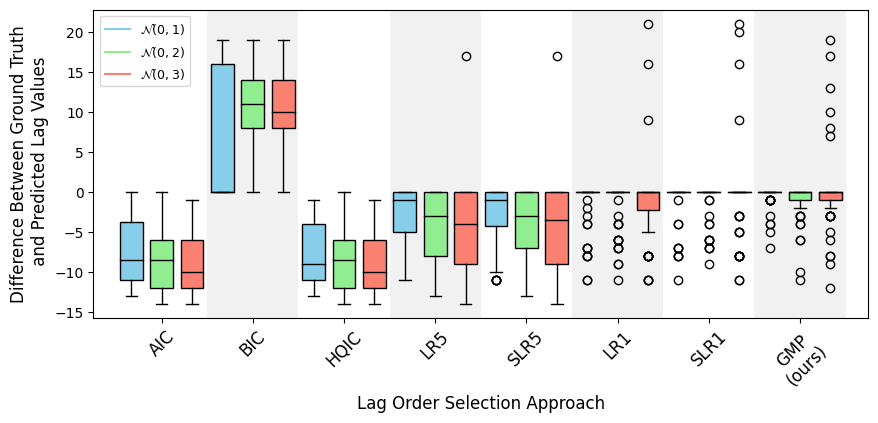

In [51]:
import matplotlib.pyplot as plt

# Grouping data into a list of lists for plotting (Adding the new datasets)
data = [aic_diffs, bic_diffs, hq_diffs, ogseqlr5_diffs, og_slr5_diffs, ogseqlr1_diffs, og_slr1_diffs, granger_diffs]
approaches = ['AIC', 'BIC', 'HQIC', 'LR5',"SLR5", 'LR1', "SLR1", 'GMP\n(ours)']
noise_levels = [r'$\mathcal{N}(0,1)$', r'$\mathcal{N}(0,2)$', r'$\mathcal{N}(0,3)$']

# Setting up the figure and axis with a smaller size for compactness
fig, ax = plt.subplots(figsize=(10, 4))  # Compact size

# Colors for each noise level
noise_colors = ['skyblue', 'lightgreen', 'salmon']

# Calculating the number of groups and the positions for each group
num_groups = len(data)
num_experiments = 3

# Reduce spacing between groups and within groups for compactness
group_width = 1.2  # Reduced spacing between groups
within_group_width = 0.4  # Reduced spacing within groups

positions = []

# Generate positions with more compact spacing
for i in range(num_groups):
    for j in range(num_experiments):
        positions.append(i * group_width + j * within_group_width)

# Alternate background colors for each group (optional for visual distinction)
for i in range(num_groups):
    start_pos = i * group_width - within_group_width / 2
    end_pos = (i + 1) * group_width - within_group_width / 2
    color = 'lightgray' if i % 2 == 1 else 'white'
    ax.axvspan(start_pos, end_pos, facecolor=color, alpha=0.3)

# Plotting each group with colors
for i, group in enumerate(data):
    for j, experiment in enumerate(group):
        pos_index = i * num_experiments + j
        ax.boxplot(experiment, positions=[positions[pos_index]], widths=0.3, patch_artist=True,  # Reduced boxplot width
                   boxprops=dict(facecolor=noise_colors[j], color='black'),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'))

# Customizing the x-axis labels with compact spacing
group_positions = [positions[i * num_experiments + num_experiments // 2] for i in range(num_groups)]
ax.set_xticks(group_positions)
ax.set_xticklabels(approaches, fontsize=12, rotation=45)  # Rotating labels for compactness

# Adding labels and title (optional title removed for compactness)
ax.set_xlabel('Lag Order Selection Approach', fontsize=12)
ax.set_ylabel('Difference Between Ground Truth\n and Predicted Lag Values', fontsize=12)

# Custom legend (made smaller and compact)
for j, label in enumerate(noise_levels):
    ax.plot([], c=noise_colors[j], label=label)
ax.legend(loc='upper left', fontsize=9)  # Smaller legend for compactness

# Save the plot as an image
# plt.savefig(base_dir + 'Lag_Order_Selection_Investigation_Notebook/compact_boxplot.png')
plt.show()


# Table of MAEs

In [52]:
# prompt: use tabulate to print my mse arrays with the use arrays columnwise and the noise along the rows

from tabulate import tabulate

def bold_text(text):
    return f"\033[1m{text}\033[0m"

table_data = [
    ["Noise Level", "AIC", "BIC", "HQ", "LR5", "LR1", "SLR5", "SLR1", "Granger"],
    ["Low Noise", aic_maes[0], bic_maes[0], hq_maes[0],  og_seqlr5_maes[0], og_seqlr1_maes[0], og_slr5_maes[0], og_slr1_maes[0], bold_text(granger_maes[0])],
    ["Medium Noise", aic_maes[1],  bic_maes[1], hq_maes[1], og_seqlr5_maes[1], og_seqlr1_maes[1], og_slr5_maes[1],bold_text(og_slr1_maes[1]), granger_maes[1]],
    ["High Noise", aic_maes[2], bic_maes[2], hq_maes[2],  og_seqlr5_maes[2], og_seqlr1_maes[2], og_slr5_maes[2], og_slr1_maes[2], bold_text(granger_maes[2])]
]

print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


+---------------+---------+----------+---------+---------+---------+---------+----------+-----------+
| Noise Level   |     AIC |      BIC |      HQ |     LR5 |     LR1 |    SLR5 |     SLR1 |   Granger |
+===============+=========+==========+=========+=========+=========+=========+==========+===========+
| Low Noise     | 6.93056 |  6.15278 | 7.25    | 3.13889 | 1.125   | 2.98611 | 0.902778 |  0.416667 |
+---------------+---------+----------+---------+---------+---------+---------+----------+-----------+
| Medium Noise  | 8.02778 | 11.4583  | 8.06944 | 4.36111 | 1.25    | 4.22222 | 0.930556 |  1.02778  |
+---------------+---------+----------+---------+---------+---------+---------+----------+-----------+
| High Noise    | 8.61111 | 11.1389  | 8.61111 | 4.70833 | 2.33333 | 4.52778 | 2.375    |  2.26389  |
+---------------+---------+----------+---------+---------+---------+---------+----------+-----------+
